# 3. Gyakorlat: $\varepsilon$-mohó ügynök 
Tegyük fel, hogy autóval utazunk Budáról Pestre. Szeretnénk a lehető legkevesebb idő alatt átérni a másik oldalra. Ehhez tartozóan két híd közül kell az egyiket választani.  
  
Néha a hidak a forgalom miatt bedugulnak, ebben az esetben sajnos elkésünk a megbeszélt találkozóról. Ha a forgalom a megszokott ütemben halad, sikerül odaérni időben.  
  
Mindkét híd különböző valószínűséggel dugulhat be. A jutalom a megszokott ütemben való átkelés és a bedugult hídon való átkelés esetében különböző. Ha a híd bedugult, a jutalom egy magas negatív érték. Ha a hídon sikerült a megszokott ütemben átkelni, a jutalom egy alacsony negatív szám. 

<img src="eps_greedy.png" alt="eps-greedy agent" width="600">

Az "A" híd bedugulásának valószínűsége: 0.18  
Az "A" híd jutalma, ha be van dugulva: -49  
Az "A" híd jutalma, ha nincs bedugulva: -9  
  
Az "B" híd bedugulásának valószínűsége: 0.29  
Az "B" híd jutalma, ha be van dugulva: -46  
Az "B" híd jutalma, ha nincs bedugulva: -12  

## Feladat
Találja meg azt az ügynököt, ami a lehető legmagasabb valószínűséggel képes megtalálni azt a hidat, amelyik éppen nincs bedugulva. Ehhez tartozóan találja meg azt a $\varepsilon$ értéket, ami a legnagyobb jutalommal jár, ezzel optimalizálva a felfedezés-kizsákmányolás dilemmát.  

## Megoldás
### Könyvtárak

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Változók definiálása
#### Jutalmak és környezeti valószínűségek

In [8]:
APjam = 0.18
ARewardJam = -49
ARewardNormal = -9

BPjam = 0.29
BRewardJam = -46
BRewardNormal = -12

# Create a Data structure rewards
rewards = {'APjam': APjam, 'ARewardJam': ARewardJam, 'ARewardNormal': ARewardNormal,
           'BPjam': BPjam, 'BRewardJam': BRewardJam, 'BRewardNormal': BRewardNormal}

#### Környezet

In [9]:
class bandit:
    def __init__(self, k, eps, iters, rewards):
        self.k = k  # Hidak (karok) száma 
        self.eps = eps  # Epszilon
        self.iters = iters  # Iterációk száma
        self.rewards = rewards  # Jutalmak
        
        self.n = 0  # Lépések száma
        self.k_n = np.zeros(k)  # Lépések száma hidanként
        self.mean_reward = 0  # Teljes átlagos jutalom
        self.reward = np.zeros(iters)  # Futtatásonkénti jutalom
        self.k_reward = np.zeros(k)  # Átlagos karonkénti jutalom
        
    def pull(self):
        # a -> action
        p = np.random.rand() # Véletlen szám
        if self.eps == 0 or self.n == 0:  # Első iteráció
            a = np.random.choice(self.k)    
        elif p < self.eps:  # Kizsákmányolás
            a = np.random.choice(self.k)
        else:  # Felfedezés
            a = np.argmax(self.k_reward)
        
        Ajammed = np.random.rand() < rewards['APjam'] # A híd be van dugulva?
        Bjammed = np.random.rand() < rewards['BPjam'] # B híd be van dugulva?
        
        # Jutalom kiszámítása
        reward = 0
        if a==0:  # Az ügynök 'A' hidat választotta
            if Ajammed:  # 'A' híd be van dugulva
                reward = rewards['ARewardJam']
            else:  # 'A' híd normális
                reward = rewards['ARewardNormal']
        
        elif a==1:  # Az ügynök 'B' hidat választotta
            if Bjammed: # 'B' híd be van dugulva
                reward = rewards['BRewardJam']
            else:  # 'B' híd normális
                reward = rewards['BRewardNormal']
        
        self.n += 1  # Összes futtatás számlálója
        self.k_n[a] += 1  # Karonkénti futtatások számlálója
        
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n  # Teljes jutalom frissítése
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]  # Karonkénti jutalom frissítése
                
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Belső változók visszaállítása
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(self.iters)
        self.k_reward = np.zeros(self.k)

### Tanítás futtatása több $\varepsilon$ értékkel
#### Függvény a tanítás futtatásához

In [10]:
def run_learning(k, eps, iters, episodes, rewards, eps_rewards, eps_selection):
    for i in range(episodes):
        b = bandit(k, eps, iters, rewards)
        b.run()
        
        eps_rewards = eps_rewards + (b.reward - eps_rewards) / (i + 1)
        eps_selection = eps_selection + (b.k_n - eps_selection) / (i + 1)
    return eps_rewards, eps_selection

#### Tanítás futtatása

In [11]:
# Hiperparaméterek definiálása
k = 2  # Karok (hidak) száma
iters = 1000  # Iterációk száma 
episodes = 1000  # Epizódok száma 
eps_rewards = np.zeros(iters)  # Epizodikus jutalmak 
eps_selection = np.zeros(k)

# Naplózási adatstruktúrák definiálása 
eps_to_try = [x/10 for x in range(0,12,2)]  # Ezek az epszilon értékek lesznek kipróbálva
results = {x:[] for x in eps_to_try}  # Adott epszilon értékhez tartozó jutalom

# Tanítás futtatása minden epszilon értékre
for eps in eps_to_try:
    result, _ = run_learning(k, eps, iters, episodes, rewards, eps_rewards, eps_selection)
    results[eps] = result

### Eredmények mutatása

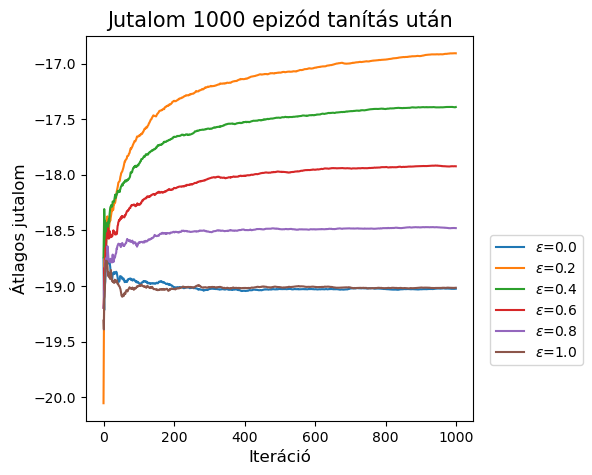

In [12]:
plt.figure(figsize=(5,5))

for eps in results.keys():
    plt.plot(results[eps], label=r"$\varepsilon$="+str(eps))

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iteráció", size=12)
plt.ylabel("Átlagos jutalom", size=12)
plt.title(f"Jutalom {episodes} epizód tanítás után", size=15)
plt.show()    